In [1]:
import numpy as np
from myplotstyle import plt, legend_ordered

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.utils import calc_cdf
from astropy.coordinates import SkyCoord
from scipy.stats import norm

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
hosts = saga.host_catalog.load(query="paper3", include_stats=True)
sats = Query(C.is_sat).filter(base)

In [5]:
rbins = np.linspace(10, 300, 2001)
sats_group_by_host = sats.group_by("HOSTID")
saga_radial = np.vstack([calc_cdf(sats_this['RHOST_KPC'], rbins) for sats_this in sats_group_by_host.groups])
saga_radial_mean = saga_radial.mean(axis=0)


def print_range(arr):
    a = np.round(arr).astype(np.int64)
    print("{}^{{+{}}}_{{-{}}}".format(a[1], a[2]-a[1], a[1]-a[0]))
    print()


def get_radial_profiles(split_function, quantile_low=0.25, quantile_high=0.75, print=False):
    x = np.fromiter(map(split_function, sats_group_by_host.groups), np.float64, len(sats_group_by_host.groups))
    if print:
        print_range(np.nanquantile(x, norm.sf([1, 0, -1])))
    xl, xh = np.nanquantile(x, [quantile_low, quantile_high])
    return saga_radial[x <= xl].mean(axis=0), saga_radial[x >= xh].mean(axis=0)


def calc_mag_gap(sats):
    if len(sats) < 2:
        return np.nan
    r = np.sort(sats["r_mag"])
    return r[1] - r[0]

def calc_mms_dist(sats):
    if np.count_nonzero(sats["log_sm"] >= 8.5) < 1:
        return np.nan
    return sats["RHOST_KPC"][np.argmax(sats["log_sm"])]

In [6]:
saga_radial_median_low, saga_radial_median_high = get_radial_profiles((lambda x: np.median(x["RHOST_KPC"])), print=True)
saga_radial_gap_low, saga_radial_gap_high = get_radial_profiles(calc_mag_gap)
saga_radial_color_low, saga_radial_color_high = get_radial_profiles((lambda x: hosts["gr"][hosts["HOSTID"] == x["HOSTID"][0]][0]))
saga_radial_mms_low, saga_radial_mms_high = get_radial_profiles(calc_mms_dist)

152^{+79}_{-65}



In [7]:
dhalf = [np.median(Query("RHOST_KPC < 150").filter(sats_this, "RHOST_KPC")) for sats_this in sats.group_by("HOSTID").groups if Query("RHOST_KPC < 150").count(sats_this)]
print_range(np.quantile(dhalf, norm.sf([1, 0, -1])))

75^{+39}_{-30}



In [8]:
from scipy.integrate import quad, cumulative_simpson

def nfw_rho(x, c=10):
    y = c*x
    return 1/y/(1+y)**2

def Sigma(rp, rho_func, r_lim=1):
    #z_lim = np.sqrt(r_lim * r_lim - rp * rp)
    z_lim = r_lim
    return quad(lambda z: rho_func(np.hypot(z, rp)), -z_lim, z_lim)[0]

def get_theory(rho_func):
    Rall = np.linspace(10, 300, 10001)[:-1] / 300
    S = np.fromiter((Sigma(R, rho_func, r_lim=1) for R in Rall), dtype=np.float64, count=len(Rall))
    S_int = cumulative_simpson(S*Rall, x=Rall, initial=0)
    S_int /= S_int[-1]
    return Rall*300, S_int

In [9]:
r_th, s_th = get_theory(nfw_rho)

In [10]:
lg = SAGA.database.FitsTable("data/McConnachie2012.fit").read()
lg["Mr"] = lg["vmag_lc"] - 0.4
lg = (Query((np.isfinite, "vmag_lc"), ~QueryMaker.equals("Name", "Canis Major"), "Mr < -12.295") | QueryMaker.equals("Name", "Andromeda")).filter(lg)
lg["Mr"][lg["Name"] == "Andromeda"] = -22

In [11]:
xyz = SkyCoord(lg["RAJ2000"], lg["DEJ2000"], lg["D"], unit=("deg", "deg", "kpc")).galactocentric.cartesian.xyz.value.T
xyz = np.vstack([xyz, [0, 0, 0]])

In [12]:
idx_m31 = np.argmax(lg["Name"] == "Andromeda")
idx_mw = len(lg)

In [13]:
def generate_projections(xyz, idx_host, idx_other, z_limit=500, n_needed=10):
    realization = []
    xyz_shifted = xyz - xyz[idx_host]
    while len(realization) < n_needed:
        m_rand = np.linalg.qr(np.random.randn(3, 3))[0]
        xyz_rot = np.dot(xyz_shifted, m_rand)
        r_proj = np.hypot(xyz_rot[:,0], xyz_rot[:,1])
        if r_proj[idx_other] < 300:
            continue
        realization.append(r_proj[(r_proj > 10) & (r_proj < 300) & (np.abs(xyz_rot[:,2]) < z_limit)])
    return realization

In [14]:
mw_realization = generate_projections(xyz, idx_mw, idx_m31, n_needed=10000)

In [15]:
m31_realization = generate_projections(xyz, idx_m31, idx_mw, n_needed=10000)

In [16]:
mw_radial = np.vstack([calc_cdf(r, rbins) for r in mw_realization])
m31_radial = np.vstack([calc_cdf(r, rbins) for r in m31_realization])

In [17]:
mw_radial_mean = mw_radial.mean(axis=0)
mw_radial_std = mw_radial.std(axis=0)
mw_radial_pct = np.quantile(mw_radial, norm.sf([1, 0, -1]), axis=0)

m31_radial_mean = m31_radial.mean(axis=0)
m31_radial_std = m31_radial.std(axis=0)
m31_radial_pct = np.quantile(m31_radial, norm.sf([1, 0, -1]), axis=0)

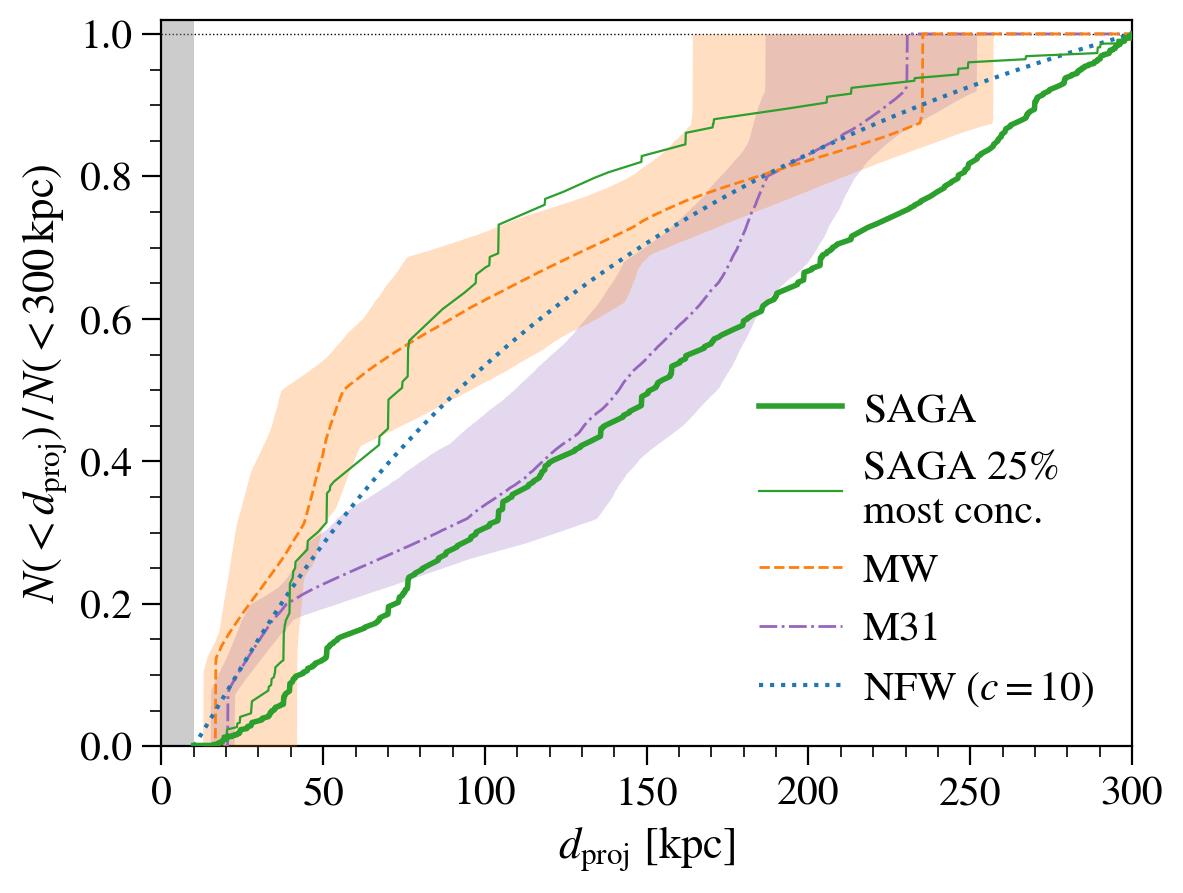

In [18]:
plt.plot(rbins, mw_radial_pct[1], c="C1", label='MW', lw=1, ls="--", zorder=20);
plt.plot(rbins, m31_radial_pct[1], c="C4", label='M31', lw=1, ls="-.", zorder=10);

plt.fill_between(rbins, mw_radial_pct[0], mw_radial_pct[2], color="C1", alpha=0.25, lw=0, zorder=5, rasterized=True);
plt.fill_between(rbins, m31_radial_pct[0], m31_radial_pct[2], color="C4", alpha=0.25, lw=0, zorder=1, rasterized=True)

plt.plot(rbins, saga_radial_mean, c="C2", label='SAGA', lw=2, zorder=50)
plt.plot(rbins, saga_radial_median_low, c="C2", label='SAGA 25%\nmost conc.', lw=0.8, zorder=40);

plt.plot(r_th, s_th, c="C0", label='NFW ($c=10$)', ls=":", zorder=30);

#plt.axhline(0.0, c='k', ls=':', lw=0.5, zorder=0);
plt.axhline(1.0, c='k', ls=':', lw=0.5, zorder=0);
plt.axvspan(0, 10, color="grey", alpha=0.4, lw=0)
#plt.axvline(10.0, c='k', ls=':', lw=0.5, zorder=0);
#plt.axvline(300.0, c='k', ls=':', lw=0.5, zorder=0);
plt.xlim(0, 300)
plt.ylim(0, 1.02)
legend_ordered([2,3,0,1,4], loc="lower right")
plt.xlabel('$d_\\mathrm{proj}$ [kpc]');
plt.ylabel('$N(<d_\\mathrm{proj}) \\, / \\, N(< 300\\,\\mathrm{kpc})$');

plt.savefig('plots/sat_radial.pdf')

<>:12: SyntaxWarning: invalid escape sequence '\,'
<>:12: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_12383/2323069203.py:12: SyntaxWarning: invalid escape sequence '\,'
  plt.ylabel('$N(<d_\\mathrm{proj}) \, / \, N(< 300\,\\mathrm{kpc})$');


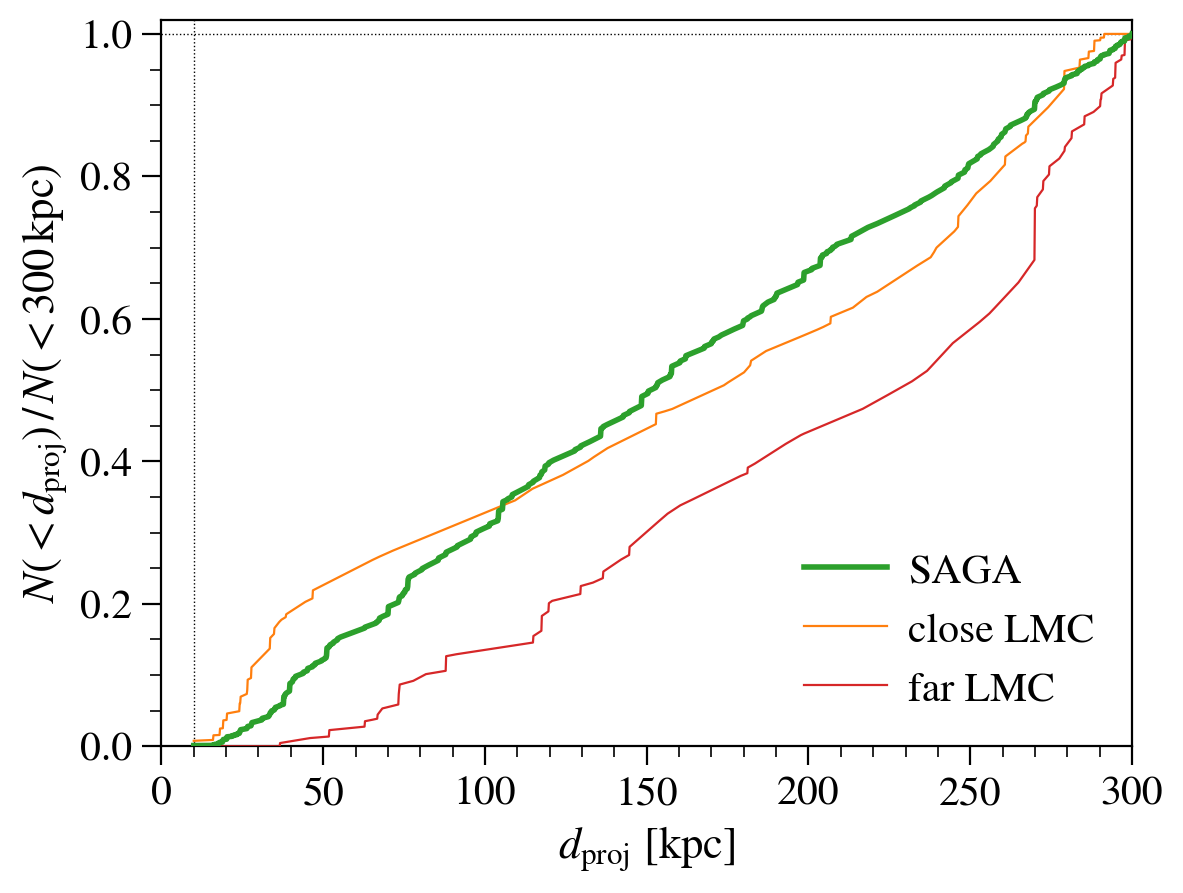

In [19]:
plt.plot(rbins, saga_radial_mean, c="C2", label='SAGA', lw=2, zorder=50)
plt.plot(rbins, saga_radial_mms_low, c="C1", label='close LMC', lw=0.8, zorder=40);
plt.plot(rbins, saga_radial_mms_high, c="C3", label='far LMC', lw=0.8, zorder=40);

#plt.axhline(0.0, c='k', ls=':', lw=0.5, zorder=0);
plt.axhline(1.0, c='k', ls=':', lw=0.5, zorder=0);
plt.axvline(10.0, c='k', ls=':', lw=0.5, zorder=0);
#plt.axvline(300.0, c='k', ls=':', lw=0.5, zorder=0);
plt.xlim(0, 300)
plt.ylim(0, 1.02)
plt.xlabel('$d_\\mathrm{proj}$ [kpc]');
plt.ylabel('$N(<d_\\mathrm{proj}) \, / \, N(< 300\,\\mathrm{kpc})$');
plt.legend()